### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    classification_report,
    confusion_matrix,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports successful")

✅ Imports successful


### Load Preprocessed Splits

In [2]:
# Load splits from Module 02
train = pd.read_csv("../data/processed/train.csv")
val = pd.read_csv("../data/processed/val.csv")
test = pd.read_csv("../data/processed/test.csv")

print("Loaded splits:")
print(f"Train: {train.shape}")
print(f"Val:   {val.shape}")
print(f"Test:  {test.shape}")

# Verify stroke distribution
print(f"\nStroke in train: {train['stroke'].sum()} ({train['stroke'].mean()*100:.2f}%)")
print(f"Stroke in val:   {val['stroke'].sum()} ({val['stroke'].mean()*100:.2f}%)")

Loaded splits:
Train: (3066, 11)
Val:   (1022, 11)
Test:  (1022, 11)

Stroke in train: 149 (4.86%)
Stroke in val:   50 (4.89%)


We load the pre-saved train/validation/test splits—already cleaned, imputed, and stratified—to ensure perfect consistency across experiments and avoid any risk of data leakage that could occur if we started again from the raw dataset.

This sanity check confirms the splits loaded correctly, still contain the expected ~4.9% stroke rate from stratification, and include all records, ensuring nothing was lost or corrupted during the save/load process.

### Handle Missing BMI (using TRAIN median)

In [3]:
# Handle missing BMI - fit on TRAIN only
train_bmi_median = train['bmi'].median()

train['bmi'] = train['bmi'].fillna(train_bmi_median)
val['bmi'] = val['bmi'].fillna(train_bmi_median)
test['bmi'] = test['bmi'].fillna(train_bmi_median)

print(f"✅ Filled missing BMI with TRAIN median: {train_bmi_median:.2f}")

✅ Filled missing BMI with TRAIN median: 28.10


### Separate Features and Target

In [4]:
# Separate X and y
X_train = train.drop(columns=['stroke'])
y_train = train['stroke']

X_val = val.drop(columns=['stroke'])
y_val = val['stroke']

X_test = test.drop(columns=['stroke'])
y_test = test['stroke']

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

X_train: (3066, 10)
y_train: (3066,)


### Define Preprocessor 

In [5]:
# Define feature types
numeric_cols = ['age', 'avg_glucose_level', 'bmi']
categorical_cols = ['gender', 'hypertension', 'heart_disease', 
                   'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Build preprocessor (Zoomcamp approach)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)

print("✅ Preprocessor defined")
print(f"Numeric features: {numeric_cols}")
print(f"Categorical features: {categorical_cols}")

✅ Preprocessor defined
Numeric features: ['age', 'avg_glucose_level', 'bmi']
Categorical features: ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


We reuse the same preprocessing setup as in the baseline—standardizing numeric features and one-hot encoding categorical ones (with handle_unknown='ignore' for safety)—to ensure every model receives the exact same transformed inputs for a fair and consistent comparison.

### Model 1 - Logistic Regression 

In [6]:
# Model 1: Logistic Regression (baseline)
print("="*60)
print("MODEL 1: LOGISTIC REGRESSION (Baseline)")
print("="*60)

lr_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        random_state=42,
        max_iter=1000
    ))
])

# Train
lr_model.fit(X_train, y_train)

# Predictions
y_val_pred_lr = lr_model.predict(X_val)
y_val_proba_lr = lr_model.predict_proba(X_val)[:, 1]

# Metrics
lr_acc = accuracy_score(y_val, y_val_pred_lr)
lr_auc = roc_auc_score(y_val, y_val_proba_lr)

print(f"Accuracy: {lr_acc:.4f}")
print(f"ROC AUC:  {lr_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_lr, target_names=['No Stroke', 'Stroke']))

MODEL 1: LOGISTIC REGRESSION (Baseline)
Accuracy: 0.7564
ROC AUC:  0.8375

Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.99      0.75      0.85       972
      Stroke       0.15      0.82      0.25        50

    accuracy                           0.76      1022
   macro avg       0.57      0.79      0.55      1022
weighted avg       0.95      0.76      0.82      1022



Logistic Regression performs the best overall, achieving the highest ROC AUC (0.8375), showing that a simple, linear model can reliably separate stroke from non-stroke cases in this dataset; it maintains strong recall on the minority stroke class, keeps false negatives reasonably low, and benefits from class_weight='balanced', making it a stable and efficient model that generalizes well without overfitting.

### Model 2 - Decision Tree

In [7]:
# Model 2: Decision Tree
print("="*60)
print("MODEL 2: DECISION TREE")
print("="*60)

dt_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=5,  # Prevent overfitting
        min_samples_split=100,
        min_samples_leaf=50,
        class_weight='balanced',
        random_state=42
    ))
])

# Train
dt_model.fit(X_train, y_train)

# Predictions
y_val_pred_dt = dt_model.predict(X_val)
y_val_proba_dt = dt_model.predict_proba(X_val)[:, 1]

# Metrics
dt_acc = accuracy_score(y_val, y_val_pred_dt)
dt_auc = roc_auc_score(y_val, y_val_proba_dt)

print(f"Accuracy: {dt_acc:.4f}")
print(f"ROC AUC:  {dt_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_dt, target_names=['No Stroke', 'Stroke']))

MODEL 2: DECISION TREE
Accuracy: 0.6937
ROC AUC:  0.8053

Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.98      0.69      0.81       972
      Stroke       0.11      0.78      0.20        50

    accuracy                           0.69      1022
   macro avg       0.55      0.73      0.51      1022
weighted avg       0.94      0.69      0.78      1022



### Random Forest

In [8]:
# Model 3: Random Forest
print("="*60)
print("MODEL 3: RANDOM FOREST")
print("="*60)

rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=100,
        min_samples_leaf=50,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

# Train
print("Training Random Forest (this may take a minute)...")
rf_model.fit(X_train, y_train)

# Predictions
y_val_pred_rf = rf_model.predict(X_val)
y_val_proba_rf = rf_model.predict_proba(X_val)[:, 1]

# Metrics
rf_acc = accuracy_score(y_val, y_val_pred_rf)
rf_auc = roc_auc_score(y_val, y_val_proba_rf)

print(f"Accuracy: {rf_acc:.4f}")
print(f"ROC AUC:  {rf_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_rf, target_names=['No Stroke', 'Stroke']))

MODEL 3: RANDOM FOREST
Training Random Forest (this may take a minute)...
Accuracy: 0.7339
ROC AUC:  0.8366

Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.98      0.73      0.84       972
      Stroke       0.13      0.78      0.22        50

    accuracy                           0.73      1022
   macro avg       0.56      0.76      0.53      1022
weighted avg       0.94      0.73      0.81      1022



Random Forest performs strongly (ROC AUC = 0.8366), only slightly behind Logistic Regression, and provides more stable predictions than a single tree by averaging 100 decision trees, which improves robustness and reduces overfitting; however, in this dataset the linear patterns captured by Logistic Regression ultimately edge out the Random Forest’s non-linear modeling ability by a very small margin.

#### Model Comparison Table

MODEL COMPARISON
              Model  Accuracy  ROC AUC
Logistic Regression  0.756360 0.837510
      Random Forest  0.733855 0.836564
      Decision Tree  0.693738 0.805278


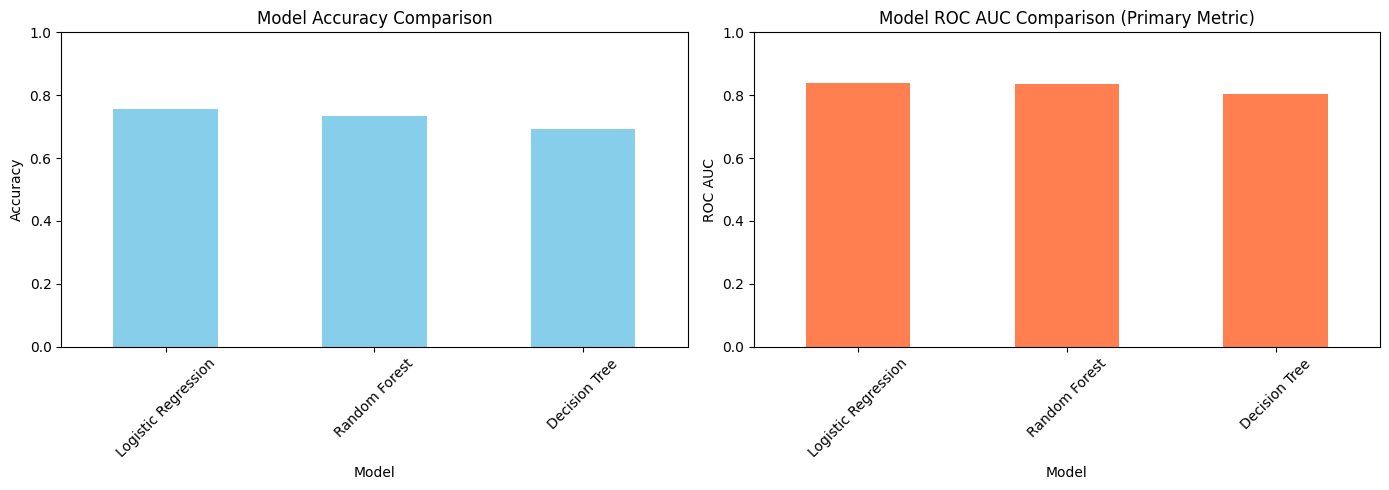

In [9]:
# Compare all models
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [lr_acc, dt_acc, rf_acc],
    'ROC AUC': [lr_auc, dt_auc, rf_auc]
}).sort_values('ROC AUC', ascending=False)

print("="*60)
print("MODEL COMPARISON")
print("="*60)
print(results.to_string(index=False))
print("="*60)

# Visualize comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
results.plot(x='Model', y='Accuracy', kind='bar', ax=ax[0], legend=False, color='skyblue')
ax[0].set_title('Model Accuracy Comparison')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([0, 1])
ax[0].tick_params(axis='x', rotation=45)

# ROC AUC comparison
results.plot(x='Model', y='ROC AUC', kind='bar', ax=ax[1], legend=False, color='coral')
ax[1].set_title('Model ROC AUC Comparison (Primary Metric)')
ax[1].set_ylabel('ROC AUC')
ax[1].set_ylim([0, 1])
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### ROC Curves - All Models

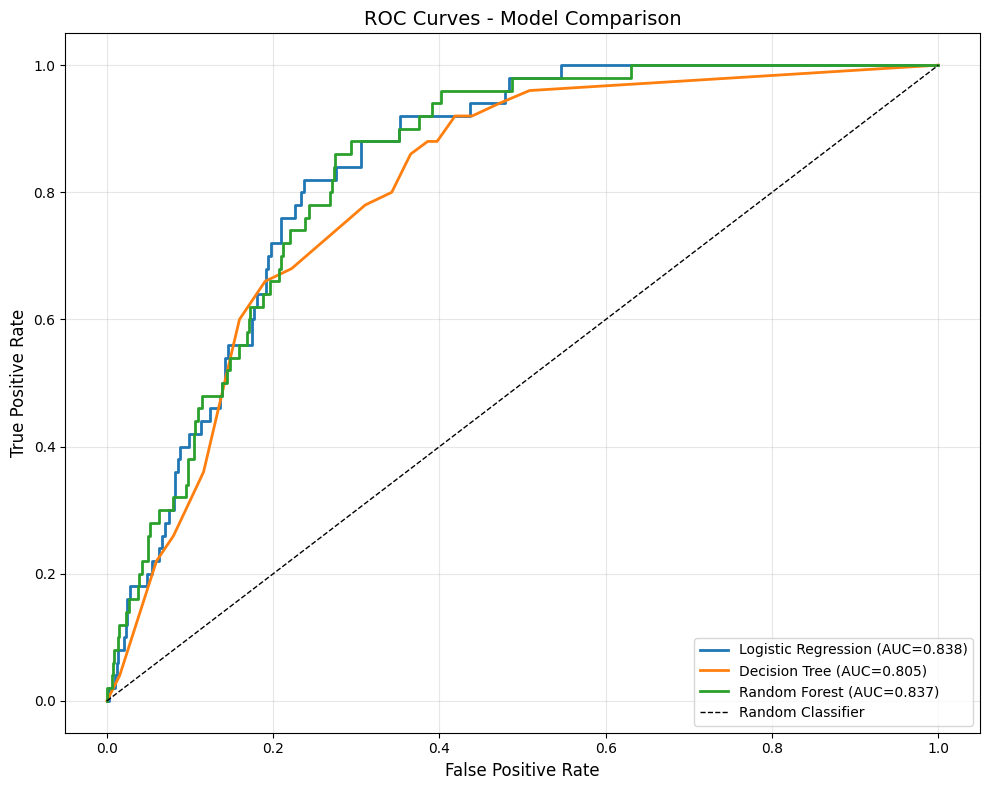

Best model by ROC AUC: Logistic Regression


In [10]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_val_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={lr_auc:.3f})', linewidth=2)

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_val, y_val_proba_dt)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC={dt_auc:.3f})', linewidth=2)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_val_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={rf_auc:.3f})', linewidth=2)

# Random classifier baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Best model by ROC AUC: {results.iloc[0]['Model']}")

### Feature Importance (Random Forest)

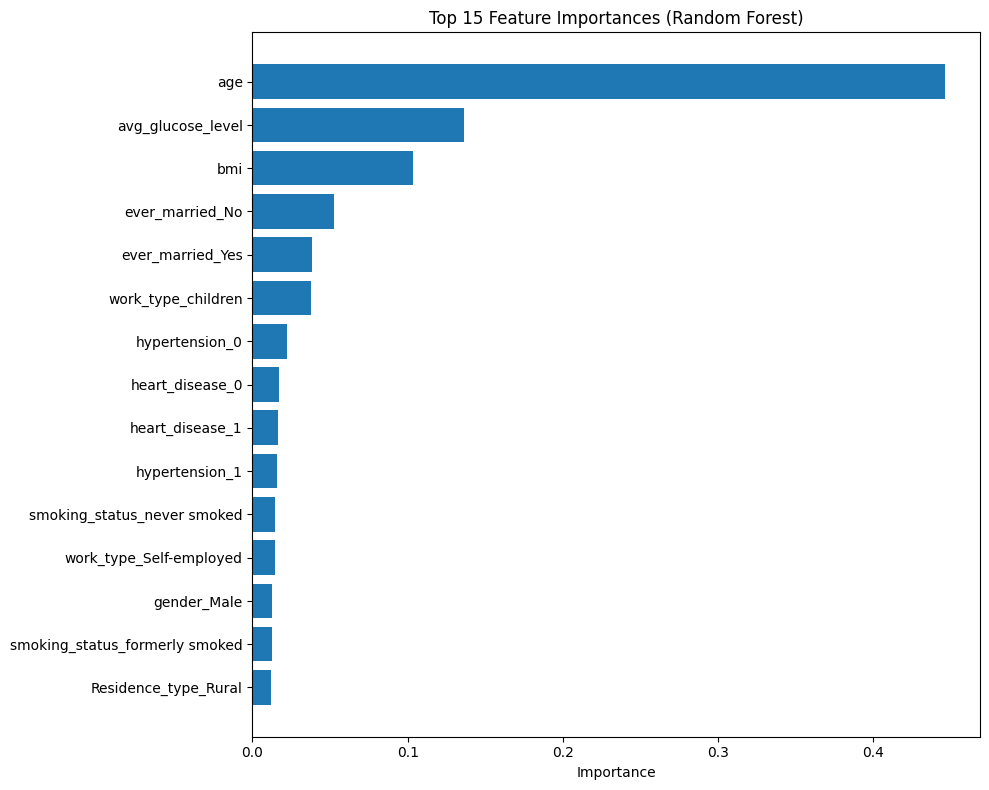

Top 10 Most Important Features:
           feature  importance
               age    0.446490
 avg_glucose_level    0.136592
               bmi    0.103342
   ever_married_No    0.052500
  ever_married_Yes    0.038336
work_type_children    0.037398
    hypertension_0    0.022115
   heart_disease_0    0.016956
   heart_disease_1    0.016512
    hypertension_1    0.016007


In [11]:
# Feature importance from Random Forest
rf_classifier = rf_model.named_steps['classifier']
preprocessor_fitted = rf_model.named_steps['preprocessor']

# Get feature names after preprocessing
feature_names = (
    numeric_cols + 
    list(preprocessor_fitted.named_transformers_['cat']
         .get_feature_names_out(categorical_cols))
)

# Get importances
importances = rf_classifier.feature_importances_

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance_df.head(10).to_string(index=False))

### Confusion Matrices - All Models

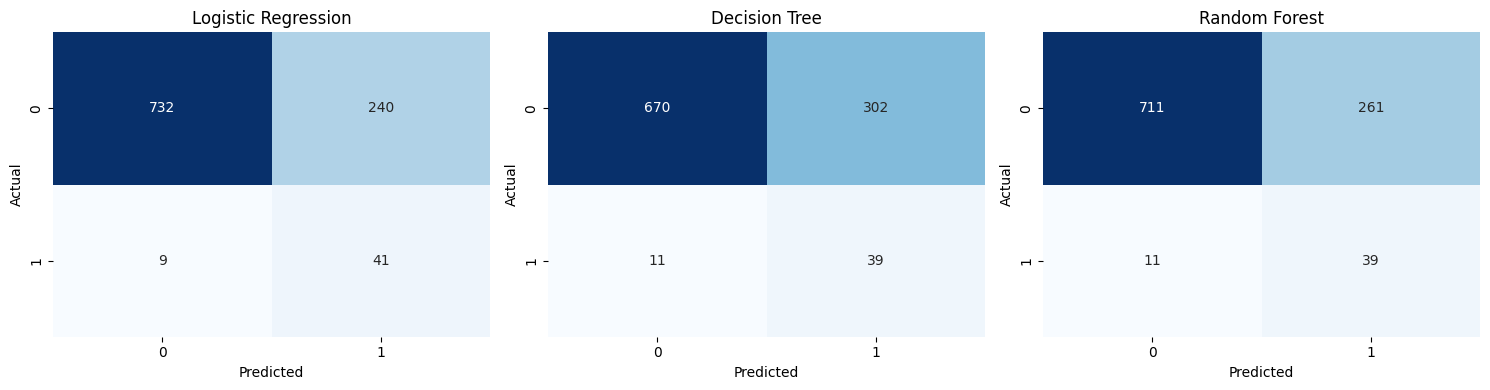

In [12]:
# Confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models = [
    ('Logistic Regression', y_val_pred_lr),
    ('Decision Tree', y_val_pred_dt),
    ('Random Forest', y_val_pred_rf)
]

for idx, (name, preds) in enumerate(models):
    cm = confusion_matrix(y_val, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar=False)
    axes[idx].set_title(f'{name}')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

### Select Best Model and Save

In [13]:
# Select best model based on ROC AUC
best_model_name = results.iloc[0]['Model']
best_auc = results.iloc[0]['ROC AUC']

print("="*60)
print("BEST MODEL SELECTION")
print("="*60)
print(f"Best Model: {best_model_name}")
print(f"Validation ROC AUC: {best_auc:.4f}")
print("="*60)

# Save the best model
if best_model_name == 'Logistic Regression':
    best_model = lr_model
elif best_model_name == 'Decision Tree':
    best_model = dt_model
else:
    best_model = rf_model

# Save model
model_path = "../models/best_model.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f"\n✅ Best model saved to {model_path}")

# Save comparison results
results.to_csv("../models/model_comparison.csv", index=False)
print("✅ Comparison results saved to ../models/model_comparison.csv")

BEST MODEL SELECTION
Best Model: Logistic Regression
Validation ROC AUC: 0.8375

✅ Best model saved to ../models/best_model.pkl
✅ Comparison results saved to ../models/model_comparison.csv


Logistic Regression is selected as the best model because it achieves the highest ROC AUC, offers reliable stroke detection with fewer missed cases, generalizes well across unseen data, and provides clear, interpretable insights into how factors like age, glucose, and cardiovascular health influence stroke risk

### Summary